In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import pingouin as pg
import matplotlib as mpl

# Read df

In [14]:
medical = pd.read_csv("results/medical_exam.csv")
medical_failure = pd.read_csv("results/medical_exam_failure_modes.csv")


# Data Cleaning/ Removing models do to deprecation
dpr = ["gpt-3.5-turbo-0613"]
for model in dpr:
    medical = medical.drop(medical.query("model_name == @model").index)
    medical_failure = medical_failure.drop(medical_failure.query("model_name == @model").index)
    
    
#display(medical.query("subtask == 'dichotomous:biochemistry:de'"))
#display(medical_failure.query("subtask == 'dichotomous:biochemistry:de'"))    


In [15]:
def score_helper(df):
    raw_results = df.copy()
    raw_results["score_possible"] = raw_results["score"].apply(
        lambda x: float(x.split("/")[1])
    )
    raw_results["scores"] = raw_results["score"].apply(
        lambda x: x.split("/")[0]
    )
    raw_results["score_achieved_total"] = raw_results["scores"].apply(
        lambda x: np.sum([float(score) for score in x.split(";")])
    )
    raw_results["iteration_scores"] = raw_results["scores"].apply(
        lambda x: [float(score) for score in x.split(";")]
    )
    raw_results["iteration_index"] = raw_results["iteration_scores"].apply(
        lambda x: list(range(1, len(x) + 1))
    )

    # Explode the iteration scores and iteration index to have a row for each iteration
    exploded_results = raw_results.explode(["iteration_scores", "iteration_index"])
    exploded_results["iteration_scores"] = exploded_results["iteration_scores"].astype(float)
    exploded_results["iteration_index"] = exploded_results["iteration_index"].astype(int)
    
    aggregated_results_iteration = exploded_results.groupby(["model_name", "iteration_index"]).agg(
        score_possible=("score_possible", "sum"),
        score_achieved_total=("iteration_scores", "sum"),
    ).reset_index()
    
    aggregated_scores = raw_results.groupby(["model_name"]).agg(
        score_possible=("score_possible", "sum"),
        score_achieved_total=("score_achieved_total", "sum"),
        iterations=("iterations", "first")
    ).reset_index()
    
   
    aggregated_scores['score_possible_total'] = aggregated_scores['score_possible'] * raw_results.iloc[:, 3][0]
    aggregated_scores['score_achieved_avg'] = aggregated_scores['score_achieved_total'] / raw_results.iloc[:, 3][0]
    
    std_results = aggregated_results_iteration.groupby(["model_name"])["score_achieved_total"].std().reset_index()
    aggregated_scores['score_achieved_std'] = std_results.iloc[:,1]
    
    return  raw_results, aggregated_scores, aggregated_results_iteration

In [16]:
agg =score_helper(medical)
agg[2].head()

,model_name,iteration_index,score_possible,score_achieved_total
0,chatglm3:6:ggmlv3:q4_0,1,357.0,155.0
1,chatglm3:6:ggmlv3:q4_0,2,357.0,148.0
2,chatglm3:6:ggmlv3:q4_0,3,357.0,154.0
3,gpt-3.5-turbo-0125,1,357.0,237.0
4,gpt-3.5-turbo-0125,2,357.0,241.0


Text(0.5, 1.0, 'Achieved score per model')

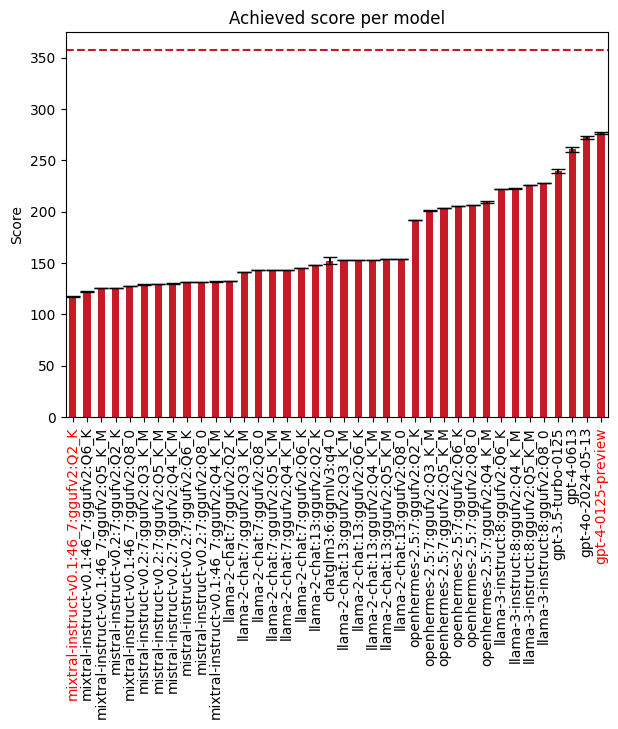

In [17]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

df = agg[1].copy()
df = df.sort_values(by="score_achieved_avg", ascending=True)

ax = df.plot.bar(x="model_name", y="score_achieved_avg", yerr="score_achieved_std", capsize = 5, ax=ax, legend=False , color="#c61a27")
plt.axhline(y=df.iloc[:, 1][0], linestyle="--", color="#c61a27")

ax.set_xlabel("")
ax.set_ylabel("Score")

ax.get_xticklabels()[-1].set_color('red')  # Change color for label 'B' specificall
ax.get_xticklabels()[0].set_color('red')  # Change color for label 'B' specifically

                   
ax.set_title("Achieved score per model")

Text(0.5, 1.0, 'Average Accuracy for Model Architectures')

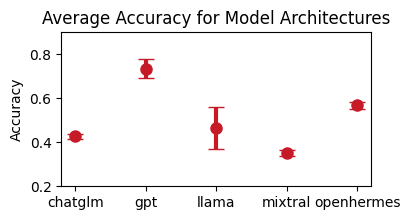

In [18]:
model_root_names = ["chatglm", "gpt", "llama", "mixtral", "openhermes"]

df = agg[2].copy()
df_avg_std_acc = []
for root_name in model_root_names:
    df_temp = df[df["model_name"].str.contains(root_name, na=False)]
    individual_accuracies = df_temp["score_achieved_total"] / df_temp["score_possible"]
    avg_accuracy = individual_accuracies.mean()
    std_accuracy = individual_accuracies.std()
    
    # Use aggregated scores to calculate overall accuracy for display
    overall_acc = df_temp["score_achieved_total"].sum() / df_temp["score_possible"].sum()
    df_avg_std_acc.append((root_name, avg_accuracy, std_accuracy, overall_acc))

df_avg_std_acc = pd.DataFrame(df_avg_std_acc, columns=["model_name", "score_achieved_avg", "score_achieved_std", "accuracy"])

fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.set_ylim(0.2, 0.9)

ax.plot(df_avg_std_acc["model_name"], df_avg_std_acc["accuracy"], marker="o", ls="", color="#c61a27", ms=8)
ax.errorbar(df_avg_std_acc["model_name"], df_avg_std_acc["accuracy"], yerr=df_avg_std_acc["score_achieved_std"], capsize=6, ls="", color="#c61a27", linewidth=3)
ax.set_ylabel("Accuracy")
ax.set_title("Average Accuracy for Model Architectures")

In [19]:
df = agg[1].copy()
df = df.sort_values(by="score_achieved_avg", ascending=True)

best_model = df.iloc[-1]
worst_model = df.iloc[0]
best_model_name = best_model.iloc[0]
worst_model_name = worst_model.iloc[0]

# Best&Worst Model Analysis

Text(0.5, 0.98, 'Comparison of Failure Modes')

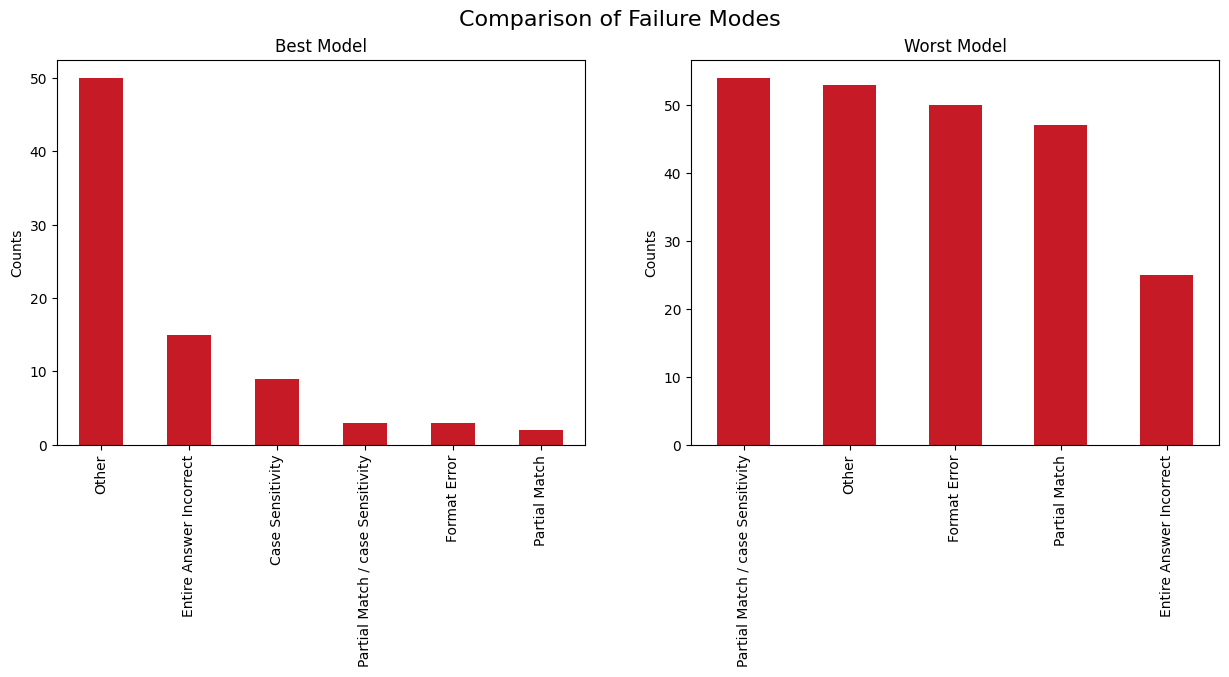

In [26]:
dfs = []
titels = ["Best", "Worst"]

dfs.append(medical_failure.query("model_name == @best_model_name"))
dfs.append(medical_failure.query("model_name == @worst_model_name"))

fig, ax = plt.subplots(1,2, figsize=(15,5))
for i, df in enumerate(dfs):
    failure_mode_count = df["failure_modes"].value_counts()
    failure_mode_count.plot.bar(ax=ax[i], title=f"{titels[i]} Model", color="#c61a27")
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Counts")
fig.suptitle('Comparison of Failure Modes', fontsize=16)
    

Text(0.5, 0.98, 'Comparison of Task Type')

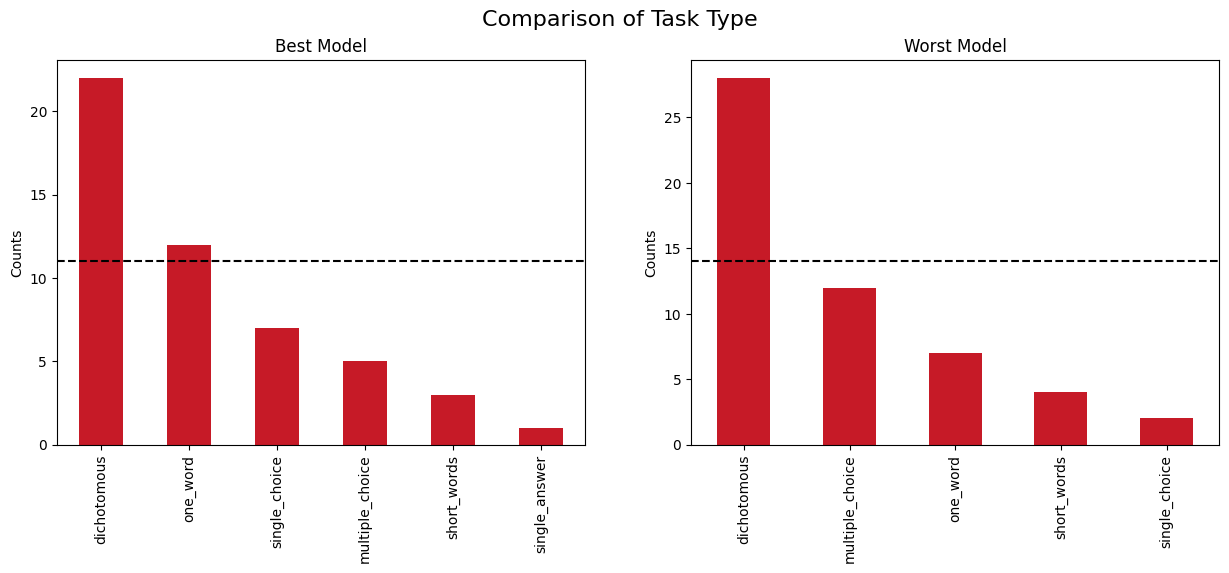

In [64]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for i, df in enumerate(dfs):
    question_type =  df.query("failure_modes == 'Other'")
    question_type = question_type['subtask'].str.split(':').str[0]
    subtask_counts = question_type.value_counts()
    subtask_counts.plot.bar(ax=ax[i], title=f"{titels[i]} Model", color="#c61a27")
    y_hline = subtask_counts.max() / 2
    ax[i].axhline(y=y_hline, linestyle="--", color="black")
    
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Counts")
fig.suptitle('Comparison of Task Type', fontsize=16)

# Unterschied der Modes

Text(0.5, 0, '')

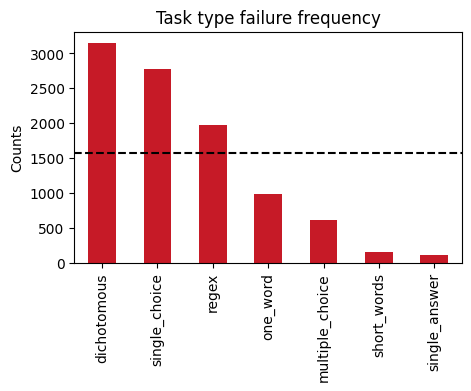

In [62]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
question_type = agg[0].copy()
question_type = question_type['subtask'].str.split(':').str[0]
subtask_counts = question_type.value_counts()
subtask_counts.plot.bar(ax=ax, title=f"Task type failure frequency", color="#c61a27")
y_hline = subtask_counts.max() / 2
ax.axhline(y=y_hline, linestyle="--", color="black")
ax.set_ylabel("Counts")
ax.set_xlabel("")

Text(0.5, 0, '')

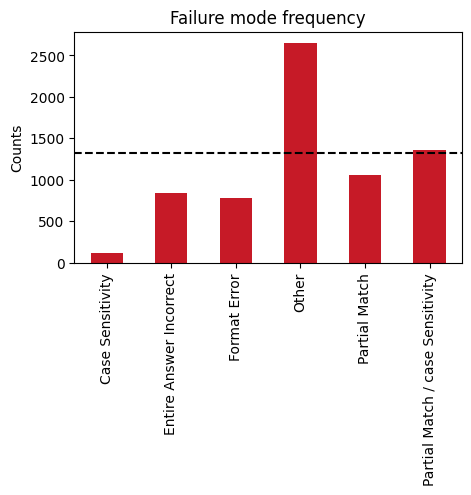

In [61]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
df = medical_failure.copy()
failure_mode_counts = df.groupby("failure_modes").size()
failure_mode_counts.plot.bar(ax=ax, title=f"Failure mode frequency", color="#c61a27")

y_hline = failure_mode_counts.max() / 2
ax.axhline(y=y_hline, linestyle="--", color="black")
ax.set_ylabel("Counts")
ax.set_xlabel("")


Text(0.5, 0, '')

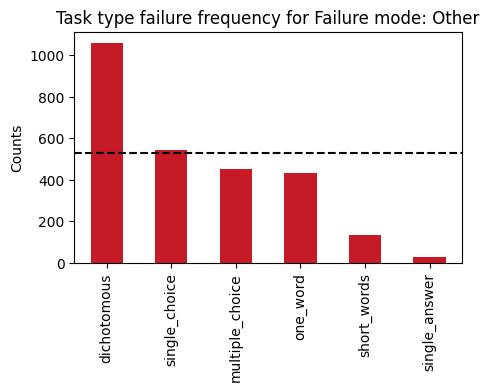

In [68]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
question_type = medical_failure.copy()
question_type = question_type.query("failure_modes == 'Other'")
question_type = question_type['subtask'].str.split(':').str[0]
subtask_counts = question_type.value_counts()
subtask_counts.plot.bar(ax=ax, title=f"Task type failure frequency for Failure mode: Other", color="#c61a27")
y_hline = subtask_counts.max() / 2
ax.axhline(y=y_hline, linestyle="--", color="black")
ax.set_ylabel("Counts")
ax.set_xlabel("")

# Sprache Analyse

In [139]:
df = agg[2].copy()
df

,model_name,iteration_index,score_possible,score_achieved_total
0,chatglm3:6:ggmlv3:q4_0,1,357.0,155.0
1,chatglm3:6:ggmlv3:q4_0,2,357.0,148.0
2,chatglm3:6:ggmlv3:q4_0,3,357.0,154.0
3,gpt-3.5-turbo-0125,1,357.0,237.0
4,gpt-3.5-turbo-0125,2,357.0,241.0
...,...,...,...,...
109,openhermes-2.5:7:ggufv2:Q6_K,2,357.0,205.0
110,openhermes-2.5:7:ggufv2:Q6_K,3,357.0,205.0
111,openhermes-2.5:7:ggufv2:Q8_0,1,357.0,206.0
112,openhermes-2.5:7:ggufv2:Q8_0,2,357.0,206.0


In [157]:
df = agg[0].copy()

langs = df['subtask'].str.split(':').str[2]
category = df['subtask'].str.split(':').str[1]

df['langs'] = langs
df['category'] = category

df["score_possible"] = df["score"].apply(
        lambda x: float(x.split("/")[1])
    )
df["score_achieved_total"] = df["scores"].apply(
    lambda x: np.sum([float(score) for score in x.split(";")])
)
df["iteration_scores"] = df["scores"].apply(
    lambda x: [float(score) for score in x.split(";")]
)
df["iteration_index"] = df["iteration_scores"].apply(
    lambda x: list(range(1, len(x) + 1))
)

exploded_results = df.explode(["iteration_scores", "iteration_index"])
exploded_results["iteration_scores"] = exploded_results["iteration_scores"].astype(float)
exploded_results["iteration_index"] = exploded_results["iteration_index"].astype(int)
 

df = exploded_results.groupby(["langs", "category", "iteration_index"]).agg(
    score_possible=("score_possible", "sum"),
    score_achieved_total=("iteration_scores", "sum"),
).reset_index()	


df["accuracy"] = df["score_achieved_total"] / (df["score_possible"])
df


,langs,category,iteration_index,score_possible,score_achieved_total,accuracy
0,de,anatomy,1,38.0,20.0,0.526316
1,de,anatomy,2,38.0,20.0,0.526316
2,de,anatomy,3,38.0,20.0,0.526316
3,de,biochemistry,1,190.0,50.0,0.263158
4,de,biochemistry,2,190.0,49.0,0.257895
...,...,...,...,...,...,...
61,en,oncology,2,456.0,263.0,0.576754
62,en,oncology,3,456.0,263.0,0.576754
63,en,physiology,1,190.0,60.0,0.315789
64,en,physiology,2,190.0,61.0,0.321053


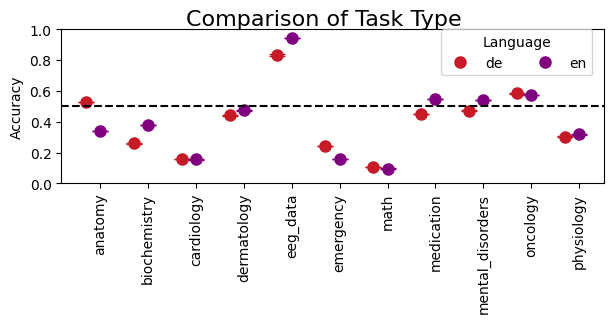

In [166]:
fig, ax = plt.subplots(1,1, figsize=(7,2))
colors = ["#c61a27", "#800080"]
offset_value = 0.3
for i, lang in enumerate(df["langs"].unique()):
    temp_df = df.query("langs == @lang")
    temp_df = temp_df.groupby("category").agg(
        accuracy=("accuracy", "mean"),
        std=("accuracy", "std"),
        langs=("langs", "first")
    ).reset_index()

     # Calculate offset for this series
    offset = (i - len(df["langs"].unique())/2) * offset_value
    x_values_with_offset = range(len(temp_df["category"]))  
    x_values_with_offset = [x + offset for x in x_values_with_offset]
    
    ax.plot(x_values_with_offset, temp_df["accuracy"], marker="o", ls="", color=colors[i], ms=8)
    ax.set_xticks(range(len(temp_df["category"]))) 
    ax.set_xticklabels(temp_df["category"], rotation=90)  
    ax.errorbar(x_values_with_offset, temp_df["accuracy"], yerr=temp_df["std"], capsize=6, ls="", color=colors[i], linewidth=3)
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axhline(y=0.5, linestyle="--", color="black")
ax.set_xlabel("")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1)
fig.suptitle('Comparison of Task Type', fontsize=16)
ax.legend(df["langs"].unique(), title="Language", bbox_to_anchor=(0.7, 1), loc='upper left', ncol=len(df["langs"].unique()), borderaxespad=0.)

In [ ]:
ax.legend(df["langs"].unique(), title="Language", bbox_to_anchor=(1.05, -0.15), loc='upper left', ncol=len(df["langs"].unique()), borderaxespad=0.)

# Statistics 

In [23]:
model_root_names = ["chatglm", "gpt", "llama", "mixtral", "openhermes"]

df = agg[2].copy()
df['accuracy'] = df['score_achieved_total'] / df['score_possible']
results = pg.anova(data=df, dv='accuracy', between='model_name')
display(results)
if(results.iloc[0, 4] < 0.05):
    print("The models have significantly different accuracies")

pos_hoc = pg.pairwise_tests(data=df, dv='accuracy', between='model_name', padjust='bonf')
display(pos_hoc)

,Source,ddof1,ddof2,F,p-unc,np2
0,model_name,37,76,8306.65015,1.041718e-123,0.999753


The models have significantly different accuracies


c:\Users\Sturm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Sturm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Sturm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Sturm\AppData\Local

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,model_name,chatglm3:6:ggmlv3:q4_0,gpt-3.5-turbo-0125,False,True,-34.877592,4.0,two-sided,4.032635e-06,0.002811,bonf,1240.092,-22.781948
1,model_name,chatglm3:6:ggmlv3:q4_0,gpt-4-0125-preview,False,True,-55.143292,4.0,two-sided,6.474839e-07,0.000451,bonf,4856.787,-36.019447
2,model_name,chatglm3:6:ggmlv3:q4_0,gpt-4-0613,False,True,-42.311396,4.0,two-sided,1.865118e-06,0.001300,bonf,2203.377,-27.637688
3,model_name,chatglm3:6:ggmlv3:q4_0,gpt-4o-2024-05-13,False,True,-50.911688,4.0,two-sided,8.907689e-07,0.000621,bonf,3826.331,-33.255376
4,model_name,chatglm3:6:ggmlv3:q4_0,llama-2-chat:13:ggufv2:Q2_K,False,True,1.982481,4.0,two-sided,1.184648e-01,1.000000,bonf,1.259,1.294951
...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,model_name,openhermes-2.5:7:ggufv2:Q4_K_M,openhermes-2.5:7:ggufv2:Q6_K,False,True,13.000000,4.0,two-sided,2.020399e-04,0.140822,bonf,70.044,8.491564
699,model_name,openhermes-2.5:7:ggufv2:Q4_K_M,openhermes-2.5:7:ggufv2:Q8_0,False,True,10.000000,4.0,two-sided,5.620036e-04,0.391717,bonf,33.953,6.531973
700,model_name,openhermes-2.5:7:ggufv2:Q5_K_M,openhermes-2.5:7:ggufv2:Q6_K,False,True,-inf,4.0,two-sided,0.000000e+00,0.000000,bonf,nan,-inf
701,model_name,openhermes-2.5:7:ggufv2:Q5_K_M,openhermes-2.5:7:ggufv2:Q8_0,False,True,-inf,4.0,two-sided,0.000000e+00,0.000000,bonf,nan,-inf
